In [1]:
import os
import boto3
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def maybe_pickle(data, filename, force=False):
    if os.path.exists(filename) and not force:
        # You may override by setting force=True.
        print('%s already present - Skipping pickling.' % filename)
    else:
        print('Pickling %s.' % filename)
        try:
            with open(filename, 'wb') as f:
                pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
        except Exception as e:
            print('Unable to save data to', filename, ':', e)


def maybe_download(table, force=False):
    storage_file = table + ".pkl"
    if force or not os.path.exists(storage_file):
        data = data_retrieve(table)
        maybe_pickle(data, storage_file)
    return storage_file
        
def data_retrieve(table, page_size=50):
    """download data from table"""
    client = boto3.client('dynamodb')
    paginator = client.get_paginator('scan')

    counter = 0
    items = []
    for page in paginator.paginate(TableName=table, PaginationConfig={"PageSize": page_size}):
        items.extend(page["Items"])
        
        counter += 1
        if counter % 50 == 0:  # print debug every 50 pages
            print("next page. {}. Count {}. ScannedCount: {}".format(counter, page["Count"], page["ScannedCount"]))


    return items
    

In [3]:
data_file = maybe_download("apthunt")
data = pickle.load(open(data_file, 'rb'))

In [4]:
# To go from dynamo format to python
from boto3.dynamodb import types

deserializer = types.TypeDeserializer()
python_data = [{k: deserializer.deserialize(v) for k,v in d.items()} for d in data]

In [5]:
df = pd.DataFrame(python_data)

In [6]:
# small cleanup of "simulated"
del df["FeedTitle"]
del df["FeedUrl"]
del df["PostContent"]
del df["PostPublished"]
del df["PostTitle"]
# delete parsed_notices. looks like it is the same
del df["parsed_notices"]
# no need for internal id
del df["intid"]
# no information from PostUrl
df["PostUrl"]
# no information from time added
del df["added"]

In [7]:
df.columns

Index(['PostUrl', 'parsed_attrs', 'parsed_data_latitude',
       'parsed_data_longitude', 'parsed_district', 'parsed_housing',
       'parsed_map_address', 'parsed_map_link', 'parsed_page_head',
       'parsed_postingbody', 'parsed_postingtitletext', 'parsed_price',
       'parsed_price_text', 'parsed_thumbs', 'parsed_titletextonly'],
      dtype='object')

In [8]:
# for col in df.columns:
#     print(col)
#     print(df[col].describe())
#     print(df[col].head())
#     print("=" * 60)

In [9]:
df.head()

,PostUrl,parsed_attrs,parsed_data_latitude,parsed_data_longitude,parsed_district,parsed_housing,parsed_map_address,parsed_map_link,parsed_page_head,parsed_postingbody,parsed_postingtitletext,parsed_price,parsed_price_text,parsed_thumbs,parsed_titletextonly
0,https://sfbay.craigslist.org/eby/apa/d/lovely-...,"[2BR / 2Ba, available jun 19, apartment, w/d h...",37.973522,-122.070774,concord / pleasant hill / martinez,2br,Maricopa at Chilpancingo,https://maps.google.com/?q=loc%3A+Maricopa+at+...,None,Lovely 2bd/2ba + den close to freeway in Pleas...,$2395 / 2br - Lovely 2bd/2ba + den close to fr...,2395,$2395,[https://images.craigslist.org/00J0J_bEViS29iF...,Lovely 2bd/2ba + den close to freeway in Pleas...
1,https://sfbay.craigslist.org/sby/apa/d/perfect...,"[2BR / 1Ba, 750ft2, available jul 19, apartmen...",37.398768,-121.961425,santa clara,2br - 750ft2,4571 Lafayette St,https://maps.google.com/?q=loc%3A+%34%35%37%31...,None,Perfectly Located 2 Bed / 1 Bath Santa Clara A...,$2100 / 2br - 750ft2 - Perfectly Located 2 Bed...,2100,$2100,[https://images.craigslist.org/00T0T_8i42v2YoR...,Perfectly Located 2 Bed / 1 Bath Santa Clara A...
2,https://sfbay.craigslist.org/nby/apa/d/studio-...,NaN,NaN,NaN,(santa rosa),/ 150ft2 -,NaN,NaN,None,NaN,$1000 / 150ft2 - *** Studio In Quite Neighborh...,1000,$1000,[https://images.craigslist.org/00Z0Z_3tHURMkfR...,*** Studio In Quite Neighborhood***
3,https://sfbay.craigslist.org/sfc/apa/d/outer-s...,"[1BR / 1Ba, available jul 1, apartment, no lau...",37.75219,-122.480671,sunset / parkside,1br,(google map),https://maps.google.com/maps/preview/@37.75219...,None,Here is a cozy apartment located close to popu...,$1900 / 1br - Outer Sunset in-law apartment (s...,1900,$1900,[https://images.craigslist.org/00O0O_bJKqnfkNh...,Outer Sunset in-law apartment
4,https://sfbay.craigslist.org/sby/apa/d/availab...,"[1BR / 1Ba, 640ft2, available jul 7, cats are ...",37.389606,-121.863833,san jose north,1br - 640ft2,1265 N Capitol Ave,https://maps.google.com/?q=loc%3A+%31%32%36%35...,None,Sierrabrook\nProperty Address\n1265 N. Capitol...,$2205 / 1br - 640ft2 - Available Now! 1 Bedroo...,2205,$2205,[https://images.craigslist.org/00I0I_lhIBFpM58...,Available Now! 1 Bedroom Apartments at Sierrab...


In [10]:
def prepare_data(df):
    new  = pd.DataFrame()
    new["latitude"] = df["parsed_data_latitude"]
    new["longitude"] = df["parsed_data_longitude"]
    new["district"] = df["parsed_district"].map(lambda s: s.strip("()") if isinstance(s, str) else s)

    new["price"] = df["parsed_price"].map(lambda x: float(x) if x else x)
    
    # # defined parts
    # new["latitude_defined"] = df["parsed_data_latitude"].notna()
    # new["longitude_defined"] = df["parsed_data_longitude"].notna()
    # new["district_defined"] = df["parsed_district"].notna()
    
    return new

In [11]:
prepare_data(df)

,latitude,longitude,district,price
0,37.973522,-122.070774,concord / pleasant hill / martinez,2395
1,37.398768,-121.961425,santa clara,2100
2,NaN,NaN,santa rosa,1000
3,37.75219,-122.480671,sunset / parkside,1900
4,37.389606,-121.863833,san jose north,2205
5,NaN,NaN,haight ashbury,3225
6,NaN,NaN,fairfield / vacaville,1730
7,38.007322,-122.305281,"hercules, pinole, san pablo, el sob",2500
8,37.9265,-122.3342,richmond / point / annex,1600
9,37.9883,-122.5937,fairfax,1500


In [12]:
p = df["parsed_price"].dropna().map(float)
p.describe()
p.quantile([0.5, 0.75, 0.8, 0.9, 1.0])

0.50        2747.0
0.75        3595.0
0.80        3845.0
0.90        4688.0
1.00    48005000.0
Name: parsed_price, dtype: float64

/Users/vist/.local/share/virtualenvs/analysis-Cchqz7iN/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


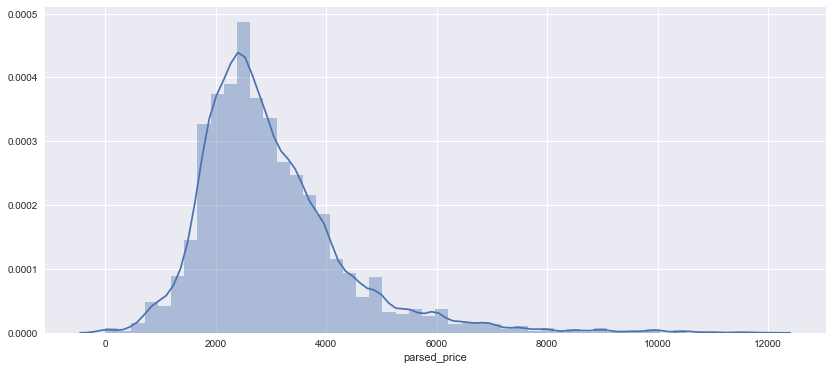

In [13]:


sns.set(color_codes=True)
plt.figure(figsize=(14, 6))

g = sns.distplot(p[p < 12000]);

In [14]:
p[p < 60000].describe()

count    56736.000000
mean      3078.017625
std       1696.868798
min          0.000000
25%       2155.000000
50%       2745.000000
75%       3595.000000
max      49800.000000
Name: parsed_price, dtype: float64

In [30]:
# p[p<1000].sort_values()
p

0        2395.0
1        2100.0
2        1000.0
3        1900.0
4        2205.0
5        3225.0
6        1730.0
7        2500.0
8        1600.0
9        1500.0
10       3100.0
11       2895.0
12       1675.0
13       2883.0
14       1050.0
15       4200.0
16       1910.0
17       2600.0
18       2295.0
20       3295.0
21       2358.0
22       2880.0
23       2465.0
24       2366.0
25       1950.0
26       2263.0
27       3050.0
28       2000.0
29       4200.0
30       2357.0
          ...  
59844    3950.0
59845    3300.0
59846    1725.0
59847    4300.0
59848    2100.0
59849    3595.0
59850    4795.0
59851    2010.0
59852    2882.0
59853    3600.0
59854    3416.0
59855    2775.0
59856    1895.0
59857    1795.0
59860    3195.0
59861    2325.0
59862    2770.0
59863    2350.0
59865    2565.0
59866    3150.0
59867    2818.0
59868    4180.0
59869    2295.0
59870    4450.0
59871    1400.0
59872    2520.0
59873    3631.0
59874    2000.0
59875    6000.0
59876    1965.0
Name: parsed_price, Leng

In [39]:
pid = 10373
print(df.iloc[pid])
print(df.iloc[pid]["PostUrl"])
print(df.iloc[pid]["parsed_thumbs"])

PostUrl                    https://sfbay.craigslist.org/sfc/apa/d/apartme...
parsed_attrs               [2BR / 1Ba, 864ft2, available jan 12, furnishe...
parsed_data_latitude                                               17.062036
parsed_data_longitude                                             -96.720886
parsed_district                                             Oaxaca de Juárez
parsed_housing                                                  2br - 864ft2
parsed_map_address                                      Murguia at 5 de mayo
parsed_map_link            https://maps.google.com/?q=loc%3A+Murguia+at+%...
parsed_page_head                                                        None
parsed_postingbody         In this neighborhood you will find the histori...
parsed_postingtitletext    $1300 / 2br - 864ft2 - apartment for rent in x...
parsed_price                                                            1300
parsed_price_text                                                      $1300

In [31]:
maybe_pickle(prepare_data(df), "train.pd")

train.pd already present - Skipping pickling.


In [36]:
df["parsed_data_latitude"].dropna().astype(float).sort_values()

10373    17.062036
9769     20.981316
4786     27.678135
16839    28.294616
13318    29.800530
59460    30.181265
45551    30.181265
7879     30.181265
47461    31.283031
55711    31.283031
46228    31.283031
47314    31.283031
35087    31.283031
38852    31.283031
54347    31.283031
8489     31.309800
51719    31.309800
53160    32.578300
40485    32.715300
26509    32.803600
38516    32.847300
20580    33.029300
32473    33.146416
4256     33.306300
59038    33.660700
59851    33.715202
49738    33.724900
39220    33.734600
24012    33.754100
19764    33.786600
           ...    
57106    39.180600
1422     39.180600
34533    39.185000
53775    39.185000
11540    39.244100
36538    39.359254
38633    39.449300
16786    39.808681
49984    40.067300
35070    40.356400
31051    40.469300
44495    40.505000
24111    40.548500
23192    40.649294
52960    40.708500
21172    40.715200
27373    40.754300
46014    40.759200
55636    40.776300
4688     40.866200
53319    41.435300
54480    41.